In [1]:
import os.path

import scanpy as sc
import scanpy.external as sce
from flecs.utils import set_seed, get_project_root
import random
import numpy as np
from flecs.sc.utils import get_cell_indices, adapt_source_population_size, \
    compute_optimal_transport, compute_env_shortest_paths_with_ot # , plot_cell_type_distribution
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import scipy
import networkx as nx
import seaborn as sns
from tqdm import tqdm

sc.set_figure_params(figsize=(16, 8))
set_seed(0)

In [2]:
use_magic = False
normalize_per_cell = True
normalize_gene_std = False
use_log1p = True

## Load

In [3]:
adata = sc.read_h5ad(os.path.join(get_project_root(), 
                                     "datasets/PerturbSeq/processed/"
                                     "K562_gwps_normalized_singlecell_with_grn.h5ad")
                    )

In [4]:
adata

AnnData object with n_obs × n_vars = 36013 × 7361
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'
    varp: 'grn_adj_mat'

In [5]:
adata.layers["counts"] = adata.X

In [6]:
adata.var["gene_id"] = adata.var.index

In [7]:
adata.var.set_index(adata.var["gene_name"].astype('object'), inplace=True)

In [8]:
adata

AnnData object with n_obs × n_vars = 36013 × 7361
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'gene_id'
    layers: 'counts'
    varp: 'grn_adj_mat'

## Cell cycle analysis

In [9]:
cell_cycle_genes = [x.strip() for x in open('/Users/paul/PycharmProjects/FLeCS/notebooks/data/'
                                            'regev_lab_cell_cycle_genes.txt')]

In [10]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

## Highly variable genes

In [11]:
sc.pp.filter_genes(adata, min_counts=1)
if normalize_per_cell:
    sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# Find highly variable genes
if not use_log1p:
    adata_copy = sc.pp.log1p(adata, copy=True)
    sc.pp.highly_variable_genes(adata_copy, n_top_genes=4000, flavor='cell_ranger')  # Expects logged data

    adata.var['highly_variable'] = adata_copy.var['highly_variable']
    
    sc.pp.scale(adata_copy)
    sc.tl.score_genes_cell_cycle(adata_copy, 
                             s_genes=list(set(adata.var["gene_name"]).intersection(s_genes)), 
                             g2m_genes=list(set(adata.var["gene_name"]).intersection(g2m_genes))
                            )
    adata.obs["phase"] = adata_copy.obs["phase"]
    
    
else:
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='cell_ranger')
    
    sc.pp.scale(adata)
    sc.tl.score_genes_cell_cycle(adata, 
                             s_genes=list(set(adata.var["gene_name"]).intersection(s_genes)), 
                             g2m_genes=list(set(adata.var["gene_name"]).intersection(g2m_genes))
                            )

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:152: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:152: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [12]:
adata

AnnData object with n_obs × n_vars = 36013 × 7361
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_counts_all', 'S_score', 'G2M_score', 'phase'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'gene_id', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'
    varp: 'grn_adj_mat'

In [13]:
adata.var.set_index(adata.var["gene_id"].astype('object'), inplace=True)

In [14]:
len(set(adata.obs["gene_id"]))

35

In [15]:
len(set(adata.var[adata.var['highly_variable']].index))

4000

In [16]:
len(set(adata.var[adata.var['highly_variable']].index).intersection(set(adata.obs["gene_id"])))

12

In [17]:
highly_variable_ko_genes = set(adata.var[adata.var['highly_variable']].index)\
                            .intersection(set(adata.obs["gene_id"]))

In [18]:
adata = adata[:, adata.var['highly_variable']].copy()

In [19]:
# Restrict ourselves to ko genes that are highly variable and observational data
indices_to_keep = adata.obs["gene_id"].apply(lambda g: g in highly_variable_ko_genes) | \
                    (adata.obs["gene"] == 'non-targeting')

In [20]:
adata = adata[indices_to_keep].copy()
adata.obs.reset_index(inplace=True)

In [21]:
adata

AnnData object with n_obs × n_vars = 16835 × 4000
    obs: 'cell_barcode', 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_counts_all', 'S_score', 'G2M_score', 'phase'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'gene_id', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'
    varp: 'grn_adj_mat'

In [22]:
if use_magic:
    sce.pp.magic(adata, t=3, n_pca=300, verbose=True)

## Compute Umap

In [23]:
def get_cell_phase_indices(_adata):
    # Get the indices of cells for the different populations
    g1_cells = list(_adata.obs[_adata.obs["phase"] == 'G1'].index)
    g2_cells = list(_adata.obs[_adata.obs["phase"] == 'G2M'].index)
    s_cells = list(_adata.obs[_adata.obs["phase"] == 'S'].index)

    return g1_cells, g2_cells, s_cells

In [24]:
def get_cell_KO_indices(_adata):
    
    KO_indices_dict = {}
    
    for KO_gene in _adata.obs["gene"].unique():
        KO_indices_dict[KO_gene] = list(_adata.obs[_adata.obs["gene"] == KO_gene].index)

    return KO_indices_dict

In [25]:
sc.tl.pca(adata, svd_solver="arpack", n_comps=50)

In [26]:
sc.pp.neighbors(adata, n_neighbors=120, n_pcs=50, knn=True, method='gauss')

In [27]:
sc.tl.umap(adata)

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


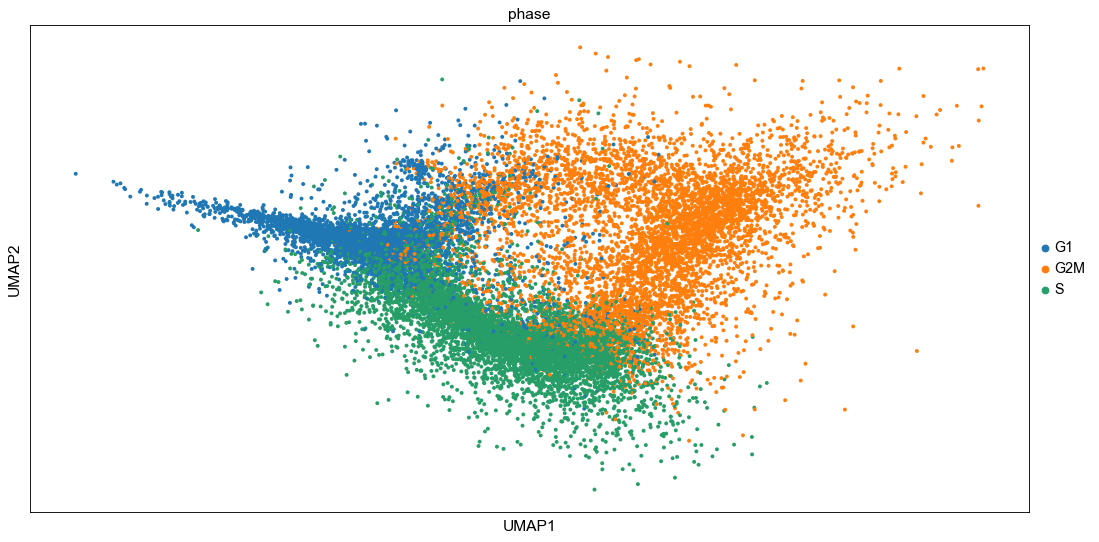

In [28]:
sc.pl.umap(adata, color="phase", size=50)

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


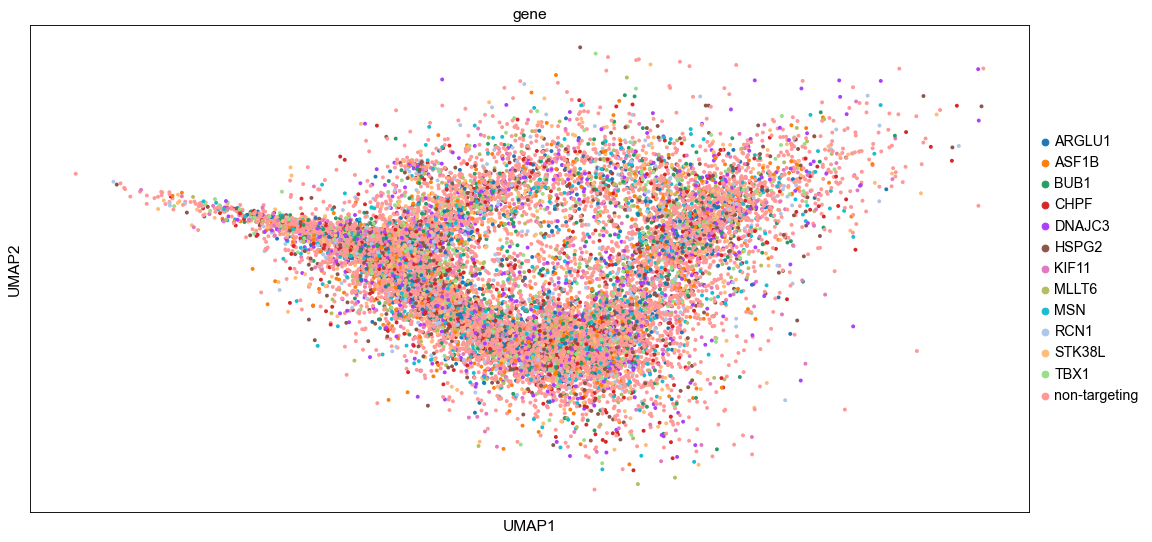

In [29]:
sc.pl.umap(adata, color="gene", size=50)

## Pseudotime

In [30]:
def compute_pseudotime_quantiles(_adata, n_bins=10):
    _adata.obs["pseudotime_quantile"] = 0

    for q in range(n_bins):
        quantile = np.quantile(_adata.obs["dpt_pseudotime"], q/n_bins)

        _adata.obs["pseudotime_quantile"] += (_adata.obs["dpt_pseudotime"] >= quantile).astype(int)

In [31]:
def set_root(_adata, targ_x, targ_y):
    _x, _y = _adata.obsm["X_umap"].T
    plt.scatter(_x, _y, s=10.)

    # Find root
    root_index = np.argmin((_adata.obsm['X_umap'][:, 0] - targ_x)**2 + (_adata.obsm['X_umap'][:, 1] - targ_y)**2)
    _adata.uns['iroot'] = root_index
    r_x, r_y = _adata[_adata.uns['iroot']].obsm["X_umap"].T

    # Plot target root as a cross
    plt.hlines(targ_y, xmin= targ_x - 0.5, xmax=targ_x + 0.5, color="r")
    plt.vlines(targ_x, ymin= targ_y - 0.5, ymax=targ_y + 0.5, color="r")

    # Plot actual root as a star
    plt.scatter(r_x, r_y, s=100., marker="*", c="r")

    return root_index


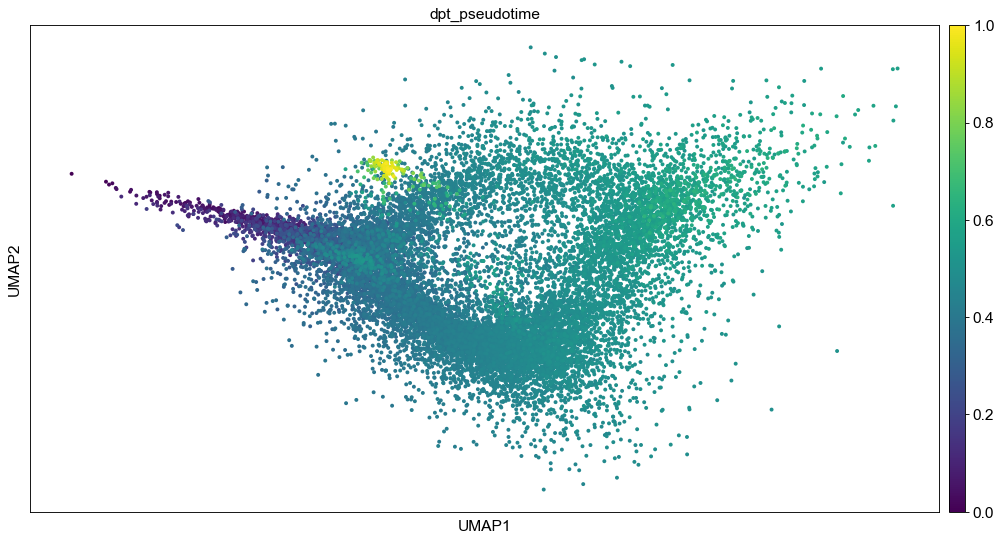

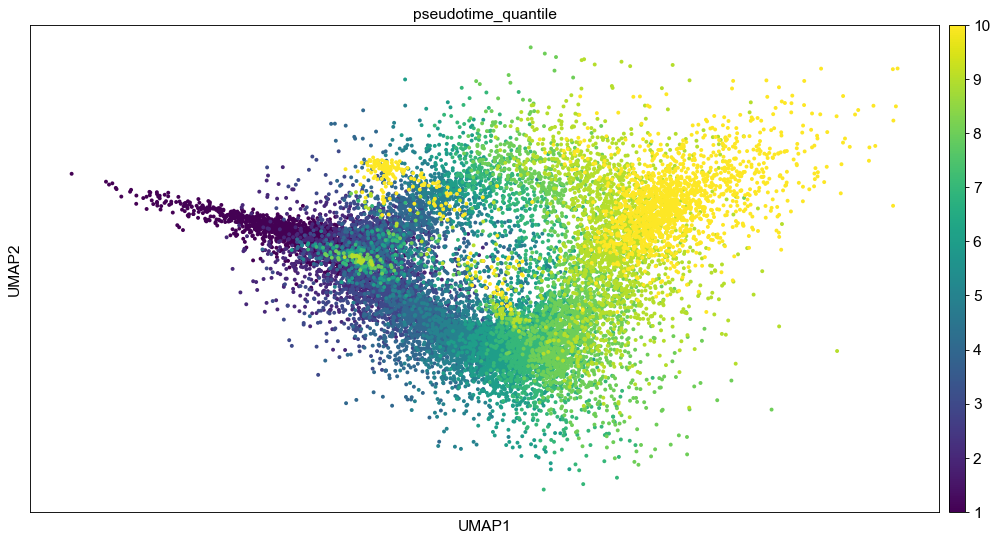

In [32]:
adata.uns['iroot'] = np.argmin(adata.obsm['X_umap'][:, 0])
sc.tl.diffmap(adata)
sc.tl.dpt(adata)
sc.pl.umap(adata, color="dpt_pseudotime", size=50)
compute_pseudotime_quantiles(adata)
sc.pl.umap(adata, color="pseudotime_quantile", size=50)

In [33]:
g1_cells, g2_cells, s_cells = get_cell_phase_indices(adata)

KO_index_dict = get_cell_KO_indices(adata)
g1_obs_cells = list(set(KO_index_dict['non-targeting']).intersection(g1_cells))
s_obs_cells = list(set(KO_index_dict['non-targeting']).intersection(s_cells))
g2_obs_cells = list(set(KO_index_dict['non-targeting']).intersection(g2_cells))

In [34]:
g1_g2_adata = adata[g2_obs_cells + g1_obs_cells].copy()
g1_s_adata = adata[g1_obs_cells + s_obs_cells].copy()
s_g2_adata = adata[s_obs_cells + g2_obs_cells].copy()

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


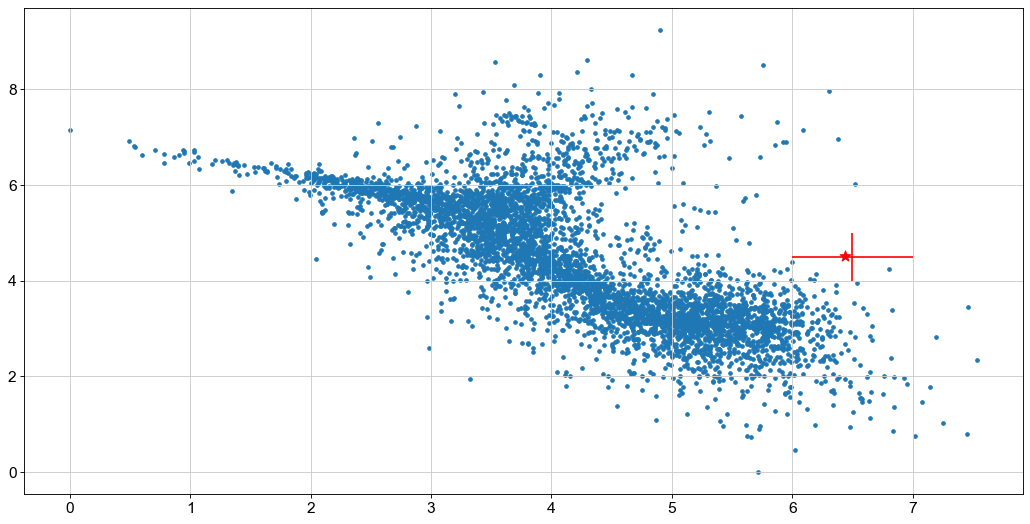

In [35]:
# g1_s_adata.uns['iroot'] = np.argmax(g1_s_adata.obsm['X_umap'][:, 0])
g1_s_root_index = set_root(g1_s_adata, 6.5, 4.5)
# set_root(g1_s_adata, 0., 7.)

In [36]:
sc.tl.diffmap(g1_s_adata)

In [37]:
sc.tl.dpt(g1_s_adata)
g1_s_adata.obs["dpt_pseudotime"] = 1. - g1_s_adata.obs["dpt_pseudotime"]

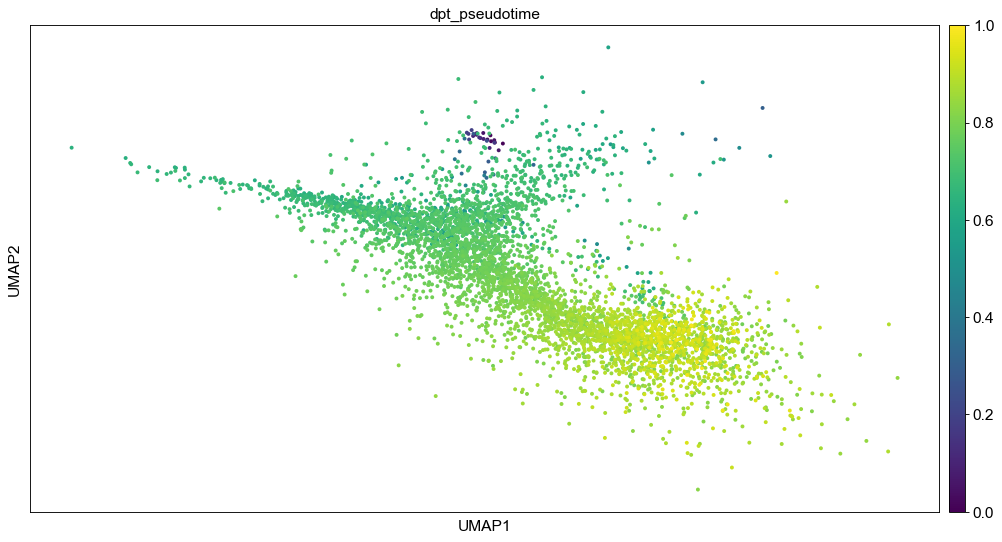

In [38]:
sc.pl.umap(g1_s_adata, color="dpt_pseudotime", size=50)

In [39]:
compute_pseudotime_quantiles(g1_s_adata)

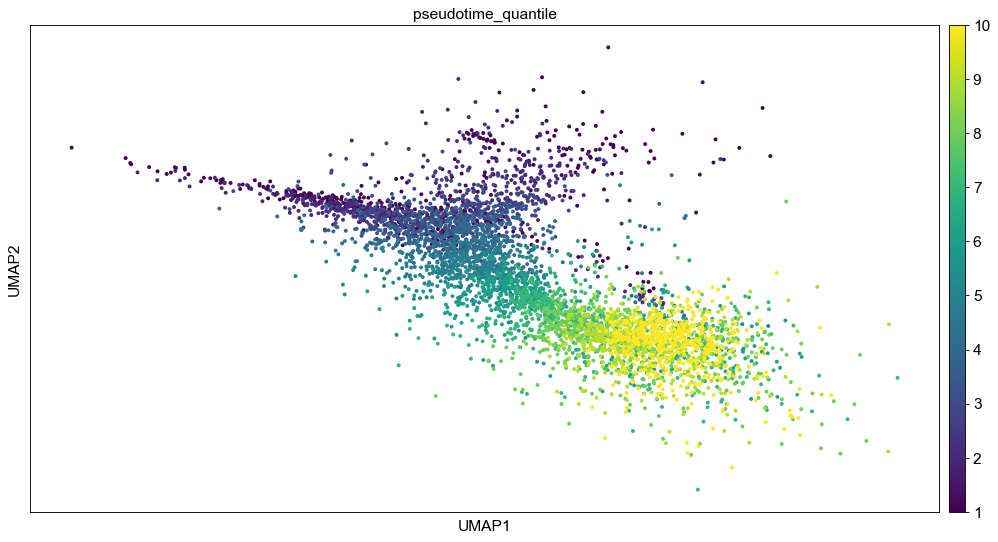

In [40]:
sc.pl.umap(g1_s_adata, color="pseudotime_quantile", size=50)

In [41]:
s_g2_root_index = np.argmin(s_g2_adata.obsm['X_umap'][:, 0])
s_g2_adata.uns['iroot'] = s_g2_root_index

In [42]:
sc.tl.diffmap(s_g2_adata)

In [43]:
sc.tl.dpt(s_g2_adata)

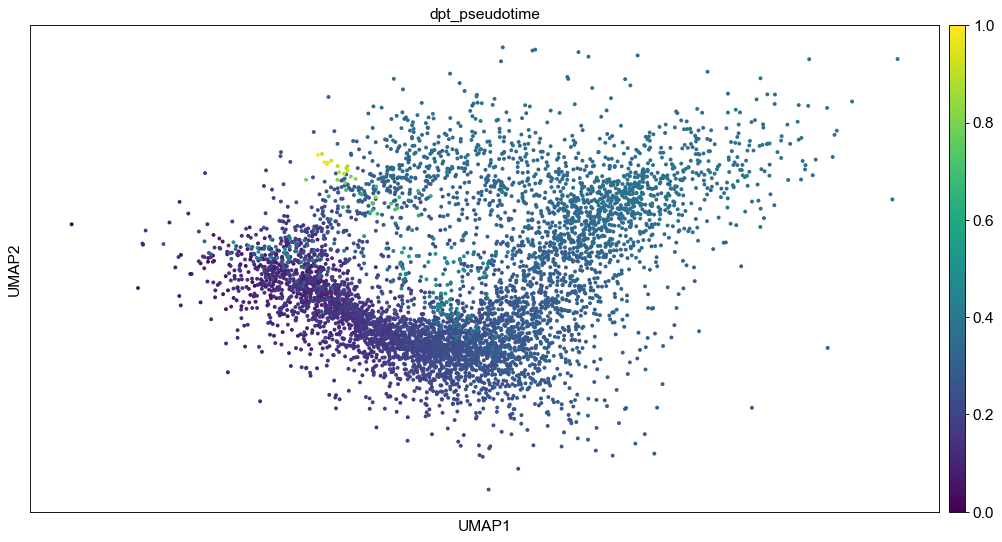

In [44]:
sc.pl.umap(s_g2_adata, color="dpt_pseudotime", size=50)

In [45]:
compute_pseudotime_quantiles(s_g2_adata)

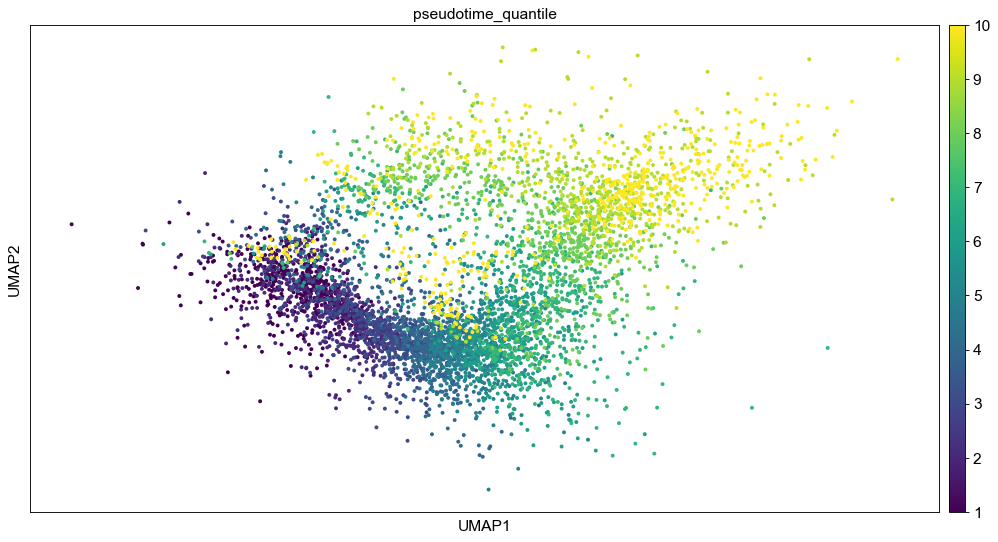

In [46]:
sc.pl.umap(s_g2_adata, color="pseudotime_quantile", size=50)

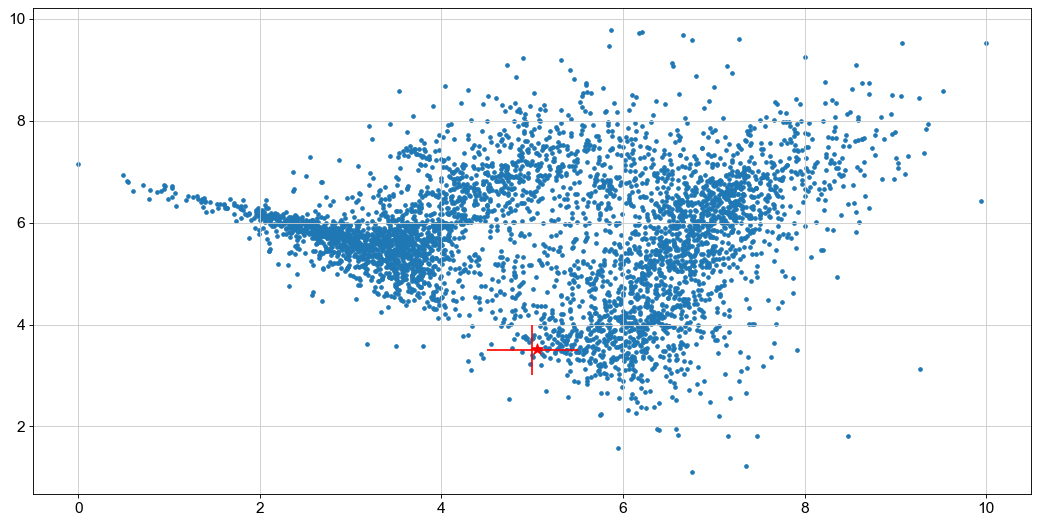

In [47]:
# g1_g2_adata.uns['iroot'] = np.argmin(g1_g2_adata.obsm['X_umap'][:, 1])
g2_g1_root_index = set_root(g1_g2_adata, 5., 3.5)

In [48]:
sc.tl.diffmap(g1_g2_adata)

In [49]:
sc.tl.dpt(g1_g2_adata)

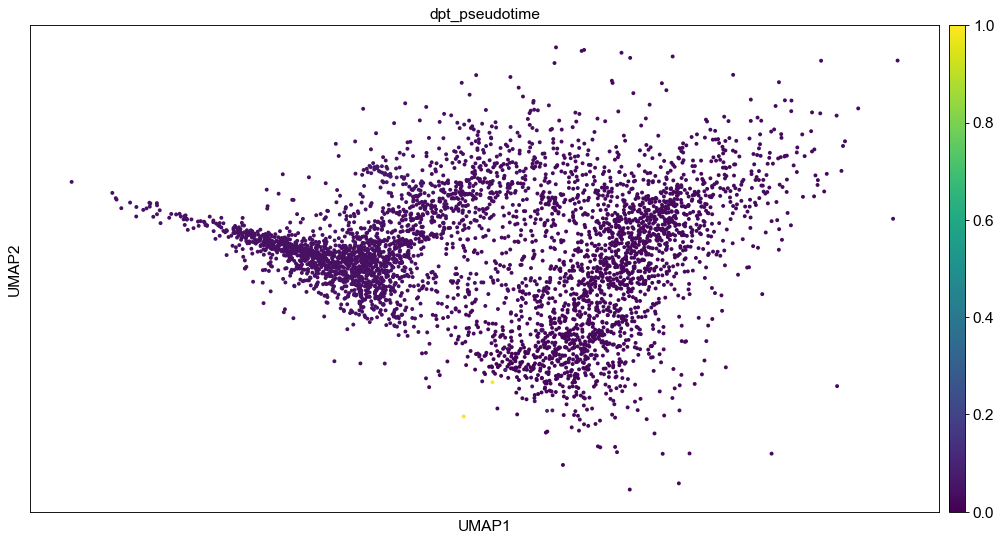

In [50]:
sc.pl.umap(g1_g2_adata, color="dpt_pseudotime", size=50)

In [51]:
compute_pseudotime_quantiles(g1_g2_adata)

In [52]:
g1_g2_adata.obs["pseudotime_quantile"].value_counts()

4     433
1     433
10    433
7     433
6     432
5     432
2     432
8     432
3     432
9     432
Name: pseudotime_quantile, dtype: int64

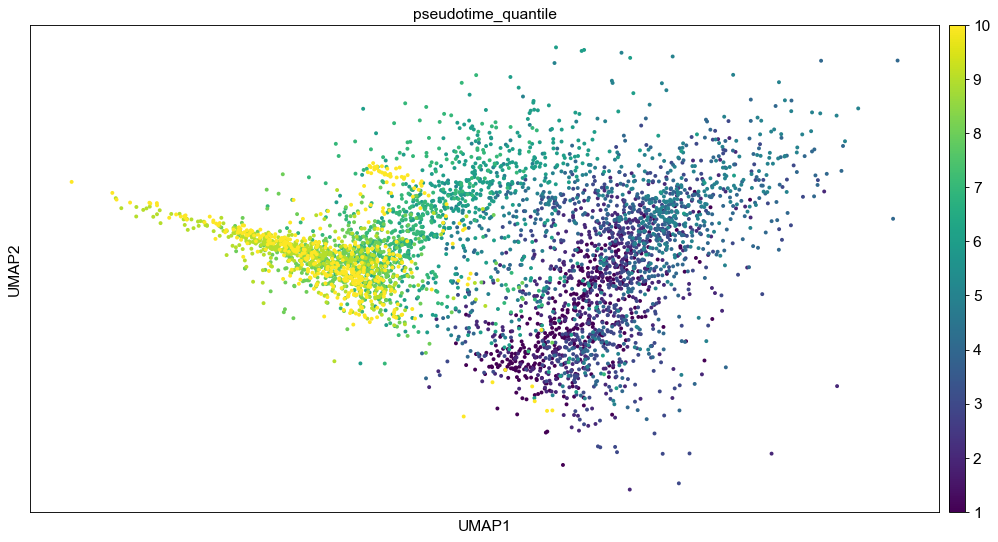

In [53]:
sc.pl.umap(g1_g2_adata, color="pseudotime_quantile", size=50)

## Compute cell paths from pseudotime

In [54]:
def compute_shortest_paths_with_ot(_adata, source_cells, target_cells, root_index, invert_dpt=False, n_bins=10):
    
    source_target_adata = _adata[source_cells + target_cells].copy()
    
    # # Choose root cell
    # assert root_axis in [0, 1]
    # assert root_sel_rule in ["min", "max"]
    
    # if root_sel_rule == "min":
    #     argfct = np.argmin
    # else:
    #     argfct = np.argmax
    
#     import pdb
#     pdb.set_trace()
    source_target_adata.uns['iroot'] = root_index  # argfct(source_target_adata.obsm['X_umap'][:, root_axis])
    
    # Compute pseudotime
    sc.tl.diffmap(source_target_adata)
    sc.tl.dpt(source_target_adata)
    if invert_dpt:
        source_target_adata.obs["dpt_pseudotime"] = 1 - source_target_adata.obs["dpt_pseudotime"]
        
    
    # Compute quantiles
    compute_pseudotime_quantiles(source_target_adata, n_bins=n_bins)
    
    # Compute OT matching
    env_shortest_paths = {}
    
    for i in range(1, n_bins):
        i_cells = source_target_adata.obs[source_target_adata.obs["pseudotime_quantile"] == i].index.tolist()
        i_p_1_cells = source_target_adata.obs[source_target_adata.obs["pseudotime_quantile"] == i+1].index.tolist()
        
        i_cells = [int(c) for c in i_cells]
        i_p_1_cells = [int(c) for c in i_p_1_cells]
        
        resampled_i_cells = adapt_source_population_size(i_cells, i_p_1_cells)
        ot_mapping = compute_optimal_transport(_adata, resampled_i_cells, i_p_1_cells)
        
        for match in ot_mapping.T:
            if match[0] in env_shortest_paths.keys():
                traj = env_shortest_paths[match[0]]
                traj.append(match[1])
                del env_shortest_paths[match[0]] 
            else:
                traj = [match[0], match[1]]
            
            env_shortest_paths[match[1]] = traj
            
    return env_shortest_paths

In [55]:
g1_cells, g2_cells, s_cells = get_cell_phase_indices(adata)

KO_index_dict = get_cell_KO_indices(adata)
g1_obs_cells = list(set(KO_index_dict['non-targeting']).intersection(g1_cells))
s_obs_cells = list(set(KO_index_dict['non-targeting']).intersection(s_cells))
g2_obs_cells = list(set(KO_index_dict['non-targeting']).intersection(g2_cells))

In [56]:
g1_s_obs_shortest_paths = compute_shortest_paths_with_ot(adata, g1_obs_cells, s_obs_cells, 
                                                         root_index=g1_s_root_index, n_bins=10, invert_dpt=True)
s_g2_obs_shortest_paths = compute_shortest_paths_with_ot(adata, s_obs_cells, g2_obs_cells, 
                                                         root_index=s_g2_root_index, n_bins=10)
g2_g1_obs_shortest_paths = compute_shortest_paths_with_ot(adata, g2_obs_cells, g1_obs_cells, 
                                                            root_index=g2_g1_root_index,  n_bins=10)

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [57]:
# Convert keys to strings
g1_s_obs_shortest_paths = {str(k): v for k, v in g1_s_obs_shortest_paths.items()}
s_g2_obs_shortest_paths = {str(k): v for k, v in s_g2_obs_shortest_paths.items()}
g2_g1_obs_shortest_paths = {str(k): v for k, v in g2_g1_obs_shortest_paths.items()}

adata.uns["g1_s_obs_shortest_paths"] = g1_s_obs_shortest_paths
adata.uns["s_g2_obs_shortest_paths"] = s_g2_obs_shortest_paths
adata.uns["g2_g1_obs_shortest_paths"] = g2_g1_obs_shortest_paths

In [58]:
# We apply the exact same processing to raw counts as for the Paul15 dataset
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_per_cell(adata)

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [59]:
sce.pp.magic(adata, t=3, n_pca=300, verbose=True)

Calculating MAGIC...
  Running MAGIC on 16835 cells and 4000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.48 seconds.
    Calculating KNN search...
    Calculated KNN search in 112.01 seconds.
    Calculating affinities...
    Calculated affinities in 115.57 seconds.
  Calculated graph and diffusion operator in 231.10 seconds.
  Calculating imputation...
  Calculated imputation in 5.80 seconds.
Calculated MAGIC in 236.98 seconds.


In [60]:
adata.write_h5ad(os.path.join(get_project_root(), 
                              "datasets", "PerturbSeq", "processed", 
                              "adata_processed_with_obs_pseudotime_paths.h5ad")
            )

## Visualization

In [61]:
def plot_cell_type_distribution(_adata, phase, ko_gene, root_cell=None, cmap_color="Reds"):
    coords = _adata[(_adata.obs["phase"] == phase) & (_adata.obs["gene"] == ko_gene)].obsm['X_umap']

    sns.kdeplot(coords[:, 0], coords[:, 1], cmap=cmap_color)

    if root_cell is not None:
        root_cell_coord = _adata.obsm["X_umap"][root_cell]
        plt.scatter(root_cell_coord[0], root_cell_coord[1], marker='*', s=10, zorder=1, c="r")


/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

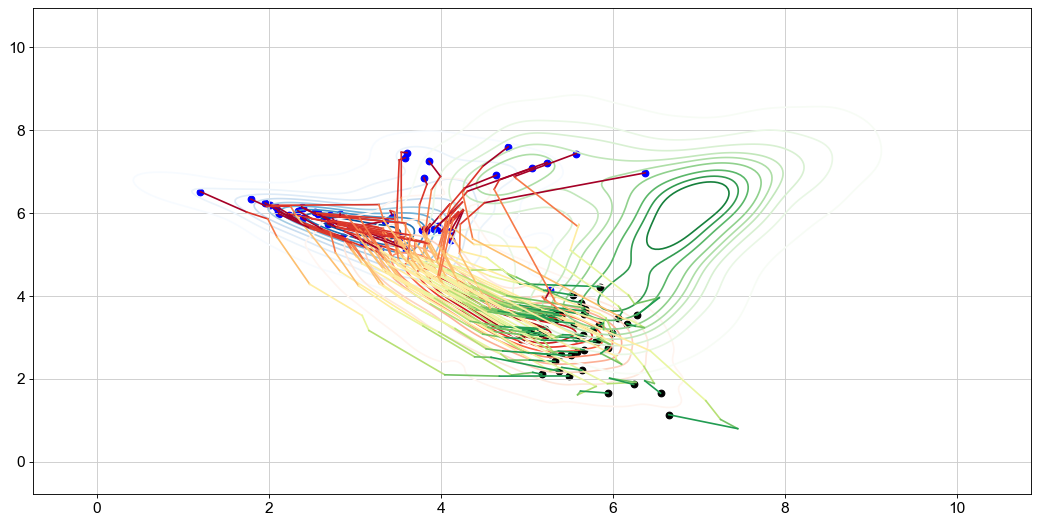

In [67]:
plot_cell_type_distribution(adata, 'G1', 'non-targeting', cmap_color="Blues")
plot_cell_type_distribution(adata, 'S', 'non-targeting', cmap_color="Reds")
plot_cell_type_distribution(adata, 'G2M', 'non-targeting', cmap_color="Greens")

cpt = 0

for path in g1_s_obs_shortest_paths.values():
    
    cpt += 1
    if cpt > 50:
        break
    
    path_coord = adata.obsm["X_umap"][path]
    
    MAP = 'RdYlGn'
    NPOINTS = len(path_coord)

    cm = plt.get_cmap(MAP)
    
    for i in range(NPOINTS-1):
        plt.plot(path_coord[i:i+2, 0], path_coord[i:i+2, 1], c=cm(1.0*i/(NPOINTS-1)))
    
    plt.scatter(path_coord[0, 0], path_coord[0, 1], marker="o", c="b")
    plt.scatter(path_coord[-1, 0], path_coord[-1, 1], marker="o", c="k")

plt.show()

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

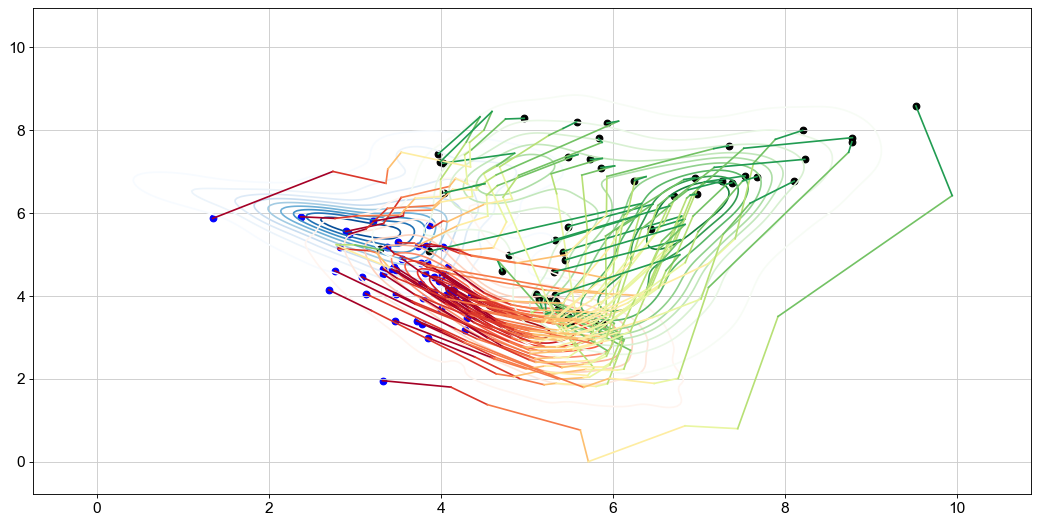

In [63]:
plot_cell_type_distribution(adata, 'G1', 'non-targeting', cmap_color="Blues")
plot_cell_type_distribution(adata, 'S', 'non-targeting', cmap_color="Reds")
plot_cell_type_distribution(adata, 'G2M', 'non-targeting', cmap_color="Greens")

cpt = 0

for path in s_g2_obs_shortest_paths.values():
    
    cpt += 1
    if cpt > 50:
        break
    
    path_coord = adata.obsm["X_umap"][path]
    
    MAP = 'RdYlGn'
    NPOINTS = len(path_coord)

    cm = plt.get_cmap(MAP)
    
    for i in range(NPOINTS-1):
        plt.plot(path_coord[i:i+2, 0], path_coord[i:i+2, 1], c=cm(1.0*i/(NPOINTS-1)))
        
    plt.scatter(path_coord[0, 0], path_coord[0, 1], marker="o", c="b")
    plt.scatter(path_coord[-1, 0], path_coord[-1, 1], marker="o", c="k")

plt.show()

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

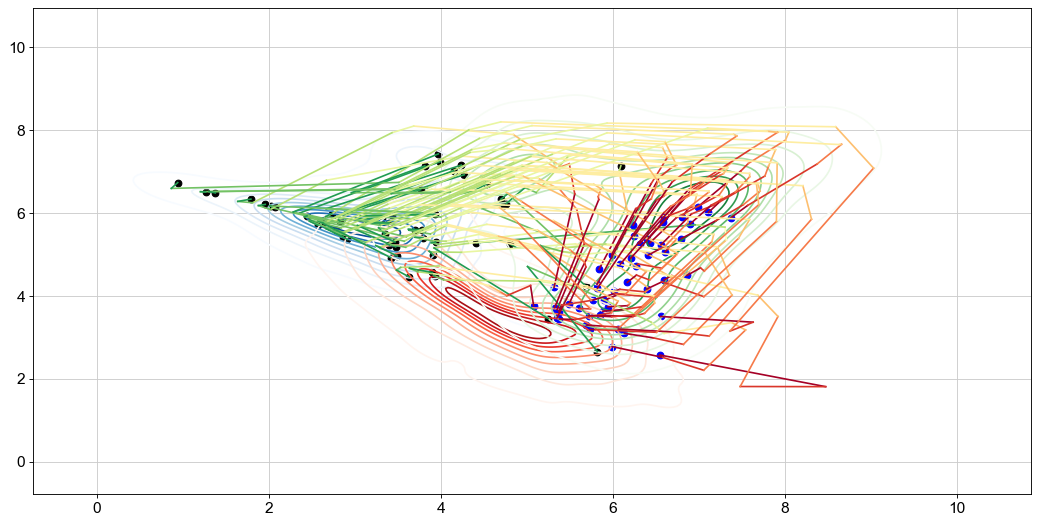

In [64]:
plot_cell_type_distribution(adata, 'G1', 'non-targeting', cmap_color="Blues")
plot_cell_type_distribution(adata, 'S', 'non-targeting', cmap_color="Reds")
plot_cell_type_distribution(adata, 'G2M', 'non-targeting', cmap_color="Greens")

cpt = 0

for path in g2_g1_obs_shortest_paths.values():
    
    cpt += 1
    if cpt > 50:
        break
    
    path_coord = adata.obsm["X_umap"][path]
    
    MAP = 'RdYlGn'
    NPOINTS = len(path_coord)

    cm = plt.get_cmap(MAP)
    
    for i in range(NPOINTS-1):
        plt.plot(path_coord[i:i+2, 0], path_coord[i:i+2, 1], c=cm(1.0*i/(NPOINTS-1)))
        
    plt.scatter(path_coord[0, 0], path_coord[0, 1], marker="o", c="b")
    plt.scatter(path_coord[-1, 0], path_coord[-1, 1], marker="o", c="k")

plt.show()